In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
print('Good to go!')

Good to go!


In [2]:
df = pd.read_csv('14100064.csv')
df.head(5)

df.shape

(940500, 19)

# Data Cleaning

In [3]:
#drop the unwanted columns. These columns are not necessary for this project.
df = df.drop(columns=['DGUID','UOM_ID','SCALAR_FACTOR','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED', 'DECIMALS'])
df = df.rename(columns={'REF_DATE': 'year', 
                        'North American Industry Classification System (NAICS)': 'naics',
                        'Sex': 'sex',
                        'Age group': 'age',
                        'VALUE': 'wage_value'})

In [4]:
#filter out some conditions to minimize the size of the dataset.
#First Let's analyze data that are specified in 
###GEO is general Canada, full-time employees and hourly wage rate 

#specify GEO to be general canada, remove all the specified province values
df = df[df['GEO'] == 'Canada']
#specify wages type to be anerage hourly wage rate
df = df[df['Wages'] == 'Average hourly wage rate']
#remove 'person' values
df = df[df['UOM'] == 'Current dollars']
#remove 'all industries' in industry type column
df = df[df['naics'] != 'Total employees, all industries']
#remove 'Both sexes' entries
df = df[df['sex'] != 'Both sexes']

#drop those filtered columns since each columns contains same values
df = df.drop(columns = ['GEO','Wages','UOM'])
df.shape


(10800, 6)

In [5]:
#check na values
df.isnull().sum()

year              0
Type of work      0
naics             0
sex               0
age               0
wage_value      365
dtype: int64

In [6]:
#drop wage_values = na
df = df.dropna()

In [7]:
#check the industry type
df['naics'].unique()

array(['Goods-producing sector', 'Agriculture [111-112, 1100, 1151-1152]',
       'Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100]',
       'Utilities [22]', 'Construction [23]', 'Manufacturing [31-33]',
       'Services-producing sector',
       'Wholesale and retail trade [41, 44-45]',
       'Transportation and warehousing [48-49]',
       'Finance, insurance, real estate, rental and leasing [52-53]',
       'Professional, scientific and technical services [54]',
       'Business, building and other support services [55-56]',
       'Educational services [61]',
       'Health care and social assistance [62]',
       'Information, culture and recreation [51, 71]',
       'Accommodation and food services [72]',
       'Other services (except public administration) [81]',
       'Public administration [91]'], dtype=object)

In [8]:
#Clean the industry type 
df['naics'] = df['naics'].map({
    'Goods-producing sector':'Goods-producing sector',
    'Agriculture [111-112, 1100, 1151-1152]': 'Agriculture', 
    'Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100]': 'Forestry, fishing, mining, quarrying, oil and gas',
    'Utilities [22]': 'Utilities',
    'Construction [23]':'Construction',
    'Manufacturing [31-33]': 'Manufacturing',
    'Services-producing sector':'Services-producing sector',
    'Wholesale and retail trade [41, 44-45]': 'Wholesale and retail trade', 
    'Transportation and warehousing [48-49]': 'Transportation and warehousing',
    'Finance, insurance, real estate, rental and leasing [52-53]': 'Finance, insurance, real estate, rental and leasing',
    'Professional, scientific and technical services [54]': 'Professional, scientific and technical services', 
    'Business, building and other support services [55-56]': 'Business, building and other support services',
    'Educational services [61]': 'Educational services',
    'Health care and social assistance [62]': 'Health care and social assistance',
    'Finance, insurance, real estate, rental and leasing [52-53]': 'Finance, insurance, real estate, rental and leasing',
    'Information, culture and recreation [51, 71]': 'Information, culture and recreation', 
    'Accommodation and food services [72]':'Accommodation and food services',
    'Other services (except public administration) [81]': 'Other services (except public administration)',
    'Public administration [91]': 'Public administration'})

df['naics'].unique()

array(['Goods-producing sector', 'Agriculture',
       'Forestry, fishing, mining, quarrying, oil and gas', 'Utilities',
       'Construction', 'Manufacturing', 'Services-producing sector',
       'Wholesale and retail trade', 'Transportation and warehousing',
       'Finance, insurance, real estate, rental and leasing',
       'Professional, scientific and technical services',
       'Business, building and other support services',
       'Educational services', 'Health care and social assistance',
       'Information, culture and recreation',
       'Accommodation and food services',
       'Other services (except public administration)',
       'Public administration'], dtype=object)

In [9]:
df['age'].unique()

array(['15 years and over', '15 to 24 years', '25 to 54 years',
       '55 years and over'], dtype=object)

In [10]:
#Clean the age column, 
#Since in the original dataset, the age group was divided into the following 4 groups,
#15 and over, 15-24, 24-54, 55+ 
#in order to make them more evenly distributed, 
#We will combine 15 and over, 15-24 these two groups together

df['age'] = df['age'].map({
    '15 years and over':'24 years and less', 
    '15 to 24 years': '24 years and less',
    '25 to 54 years': '25 to 54 years',
    '55 years and over': '55 years and over'})

#keep only 25-54 year age group
df = df[df['age'] == '25 to 54 years']

df['age'].unique()
df['sex'].unique()


array(['Males', 'Females'], dtype=object)

# Type of work = Full_time employees analysis

In [11]:
#First analyze 'Type of work' = 'Full-time employees' data
ft = df[df['Type of work'] == 'Full-time employees']
ft.head()

ft = ft.drop(columns = ['age','Type of work'])


# Measure how accurate our models are for all industries than create predictions to 2050

Create regression and prediction for each industry

In [12]:
def plot_regression(y_true, y_pred, title="", axis_label=""):
  y_residual = np.abs(y_true-y_pred)
  fig, ax = plt.subplots(figsize=(10,10))
  scatter = ax.scatter(x=y_true, y=y_pred, c=y_residual, cmap="cool", marker="o", s=100, alpha=0.8)
  ax.set_xlabel("Actual %s"%axis_label, fontsize=16); ax.set_ylabel("Predicted %s"%axis_label, fontsize=16); 
  ax.set_title(title, fontsize=18);
  ax.set_xlim(5, 55); ax.set_ylim(5, 55);
  ax.set_aspect(1)
  cbar = plt.colorbar(scatter)
  cbar.ax.set_ylabel("Residual", rotation=90, fontsize=16)
  ax.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], "r--", alpha=0.75, linewidth=3)
  from sklearn.metrics import r2_score
  R_squared = r2_score(y_true, y_pred)
  plt.figtext(0.22,0.85,"$R^{2}$ = "+str(R_squared.round(3)), fontsize=16, ha="center",backgroundcolor=(0,0,0,0.4),color="w")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 930 to 904018
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        900 non-null    int64  
 1   naics       900 non-null    object 
 2   sex         900 non-null    object 
 3   wage_value  900 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 35.2+ KB
Goods-producing sector R²: 0.9945305729969871
Agriculture R²: 0.9655838892570272
Forestry, fishing, mining, quarrying, oil and gas R²: 0.9891964995414397
Utilities R²: 0.9522355773223666
Construction R²: 0.9916832811483822
Manufacturing R²: 0.9905359418891156
Services-producing sector R²: 0.9895127239356323
Wholesale and retail trade R²: 0.9696643840878806
Transportation and warehousing R²: 0.9834386438052257
Finance, insurance, real estate, rental and leasing R²: 0.9842976404849666
Professional, scientific and technical services R²: 0.9892007035796649
Business, building and 

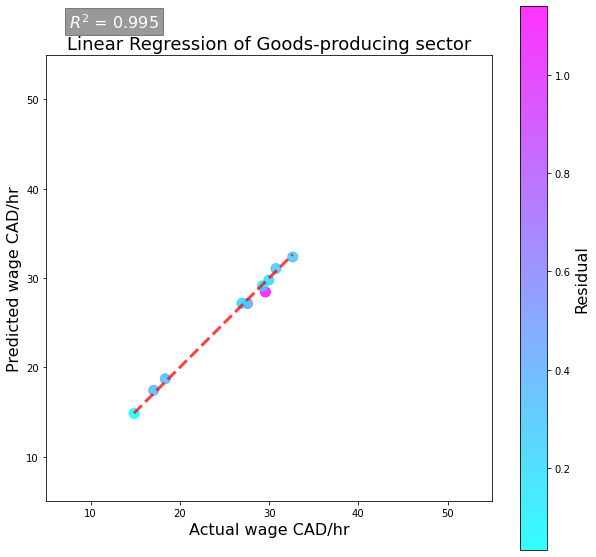

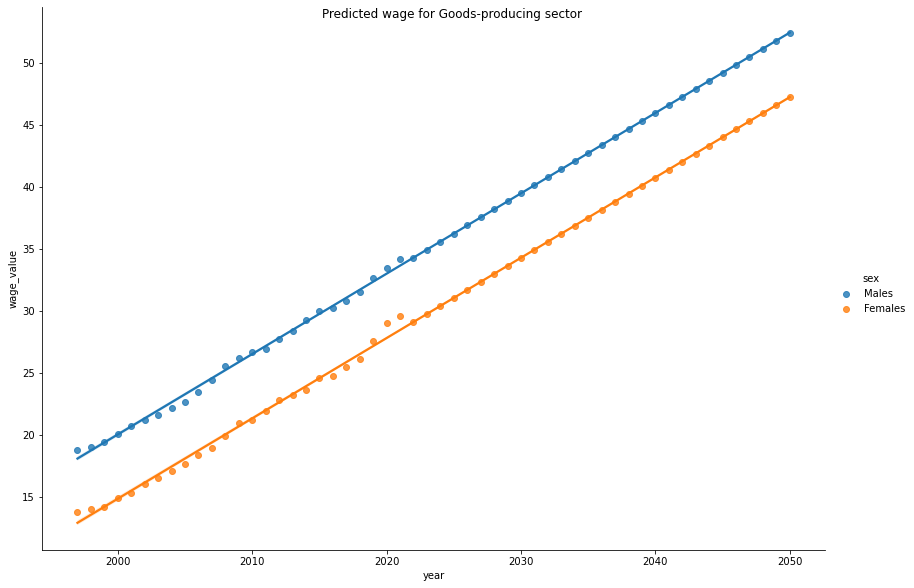

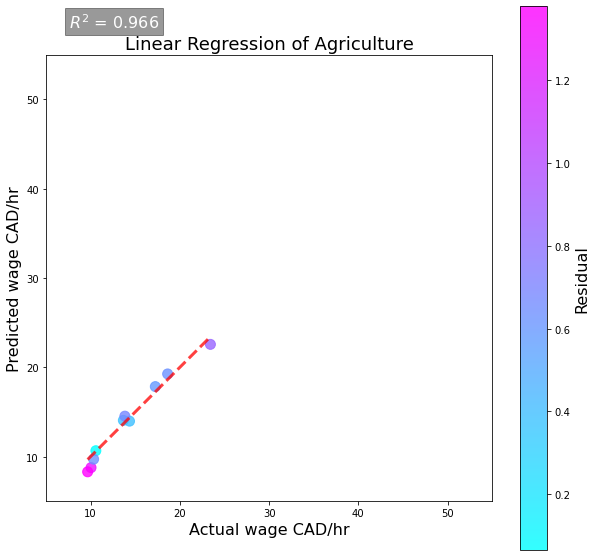

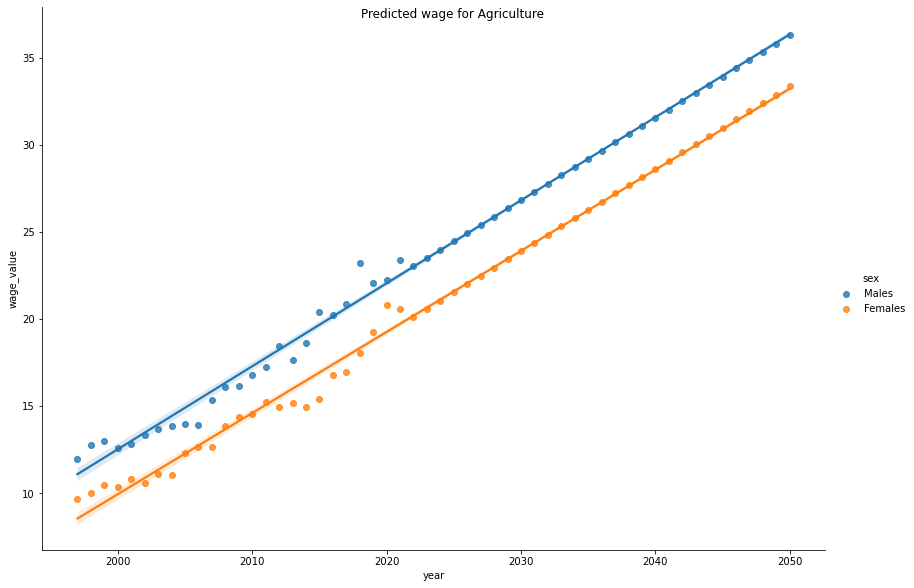

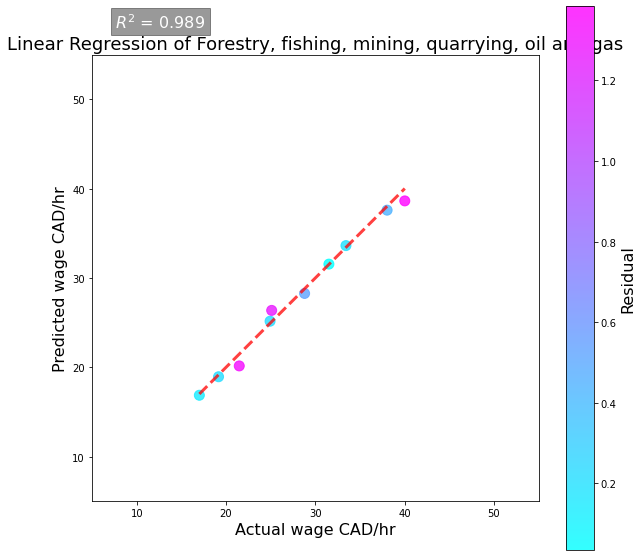

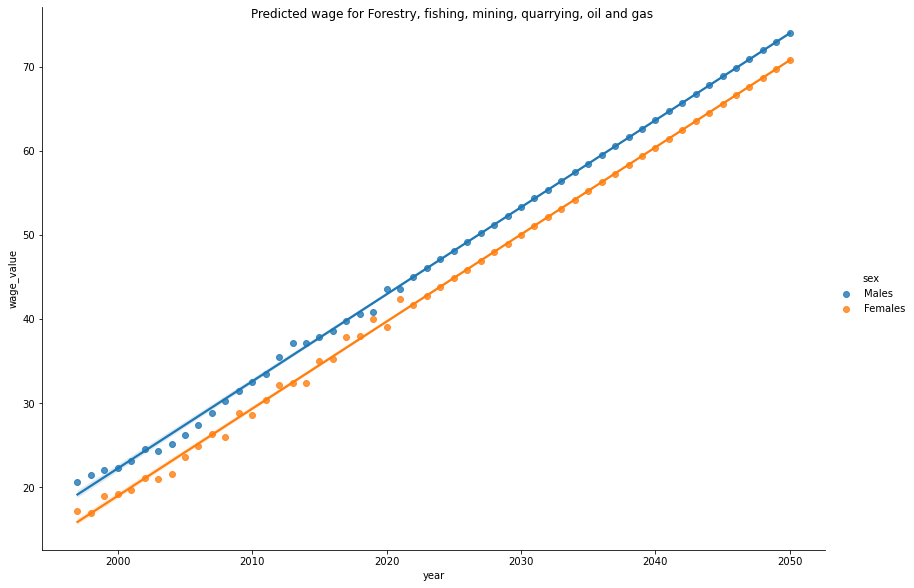

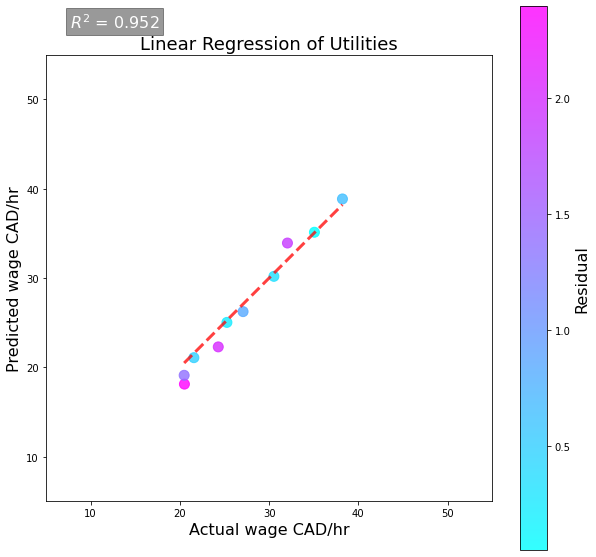

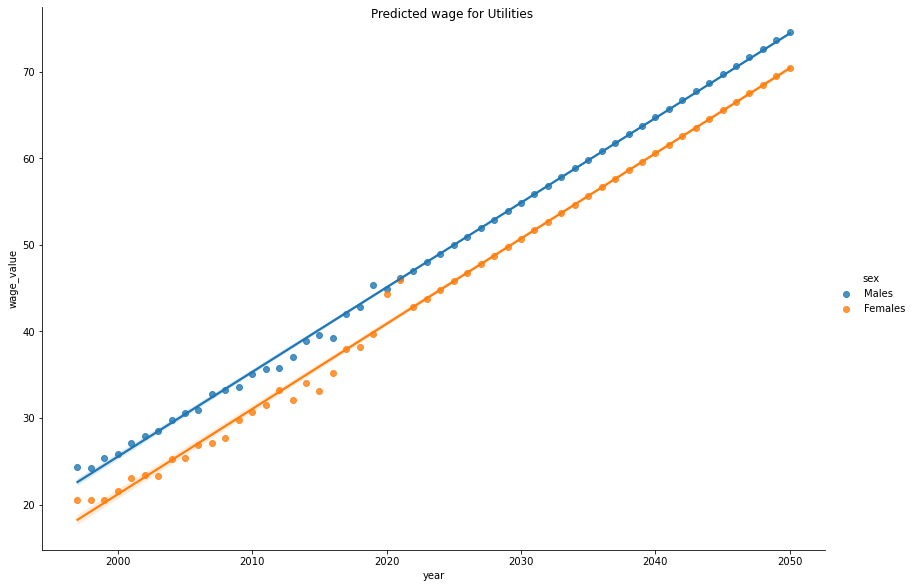

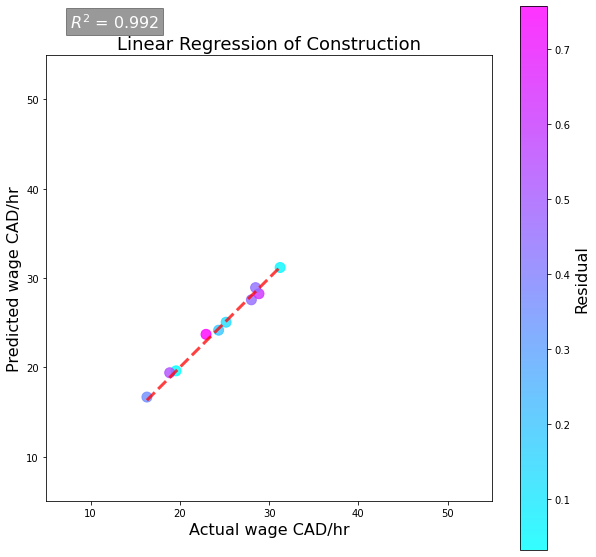

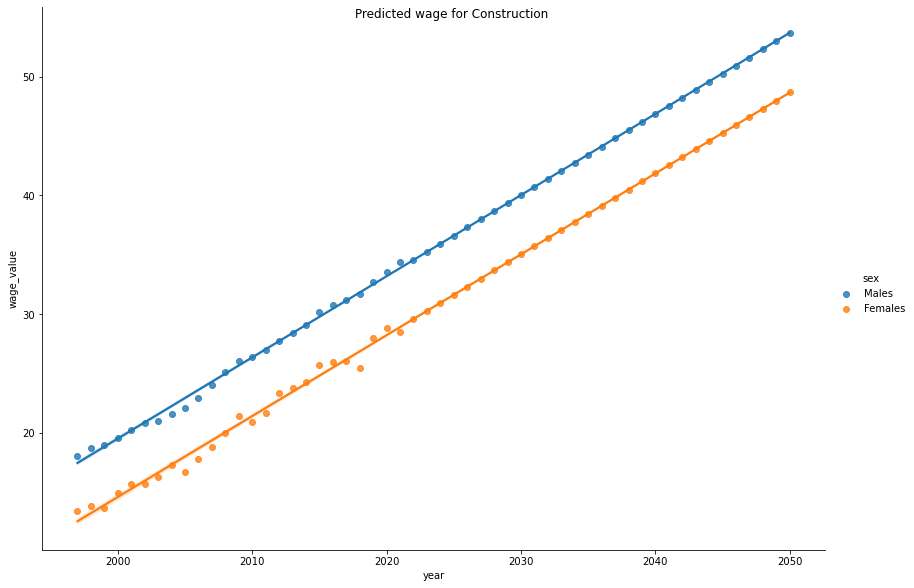

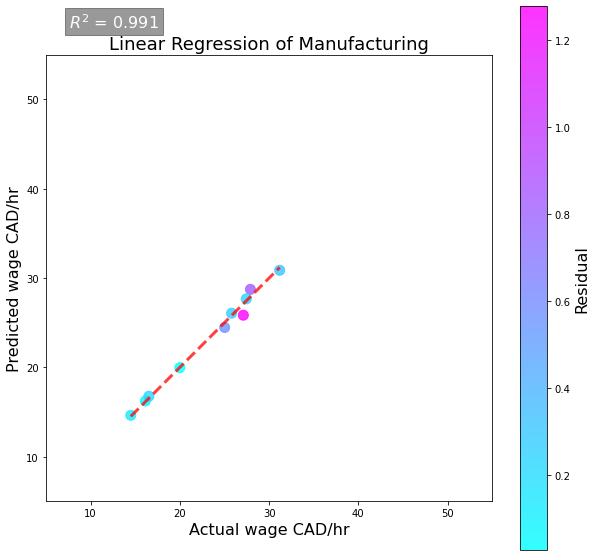

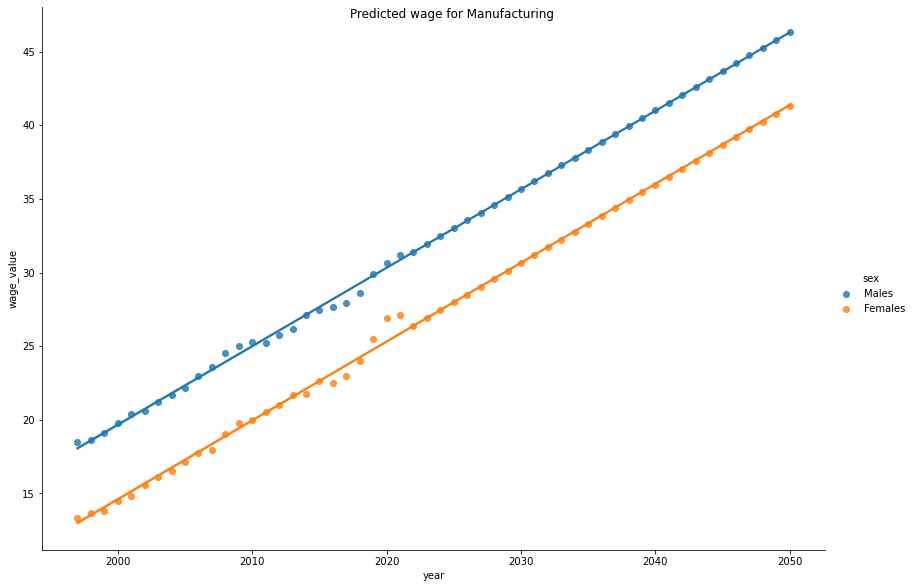

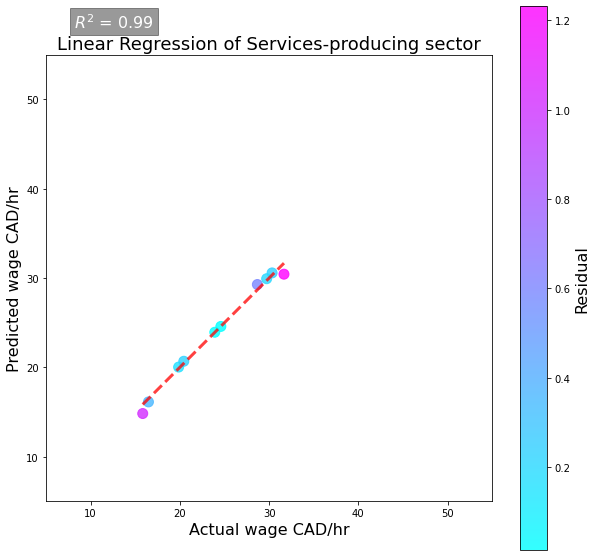

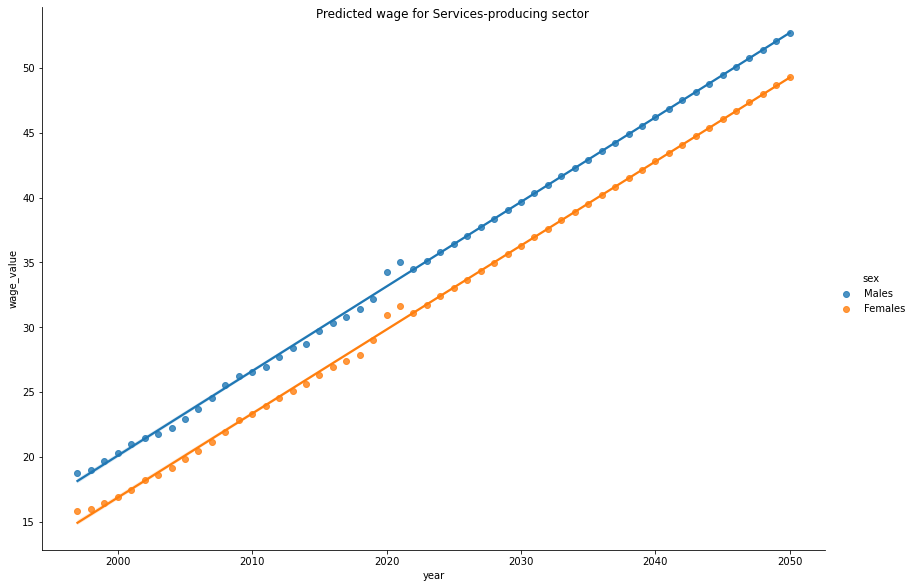

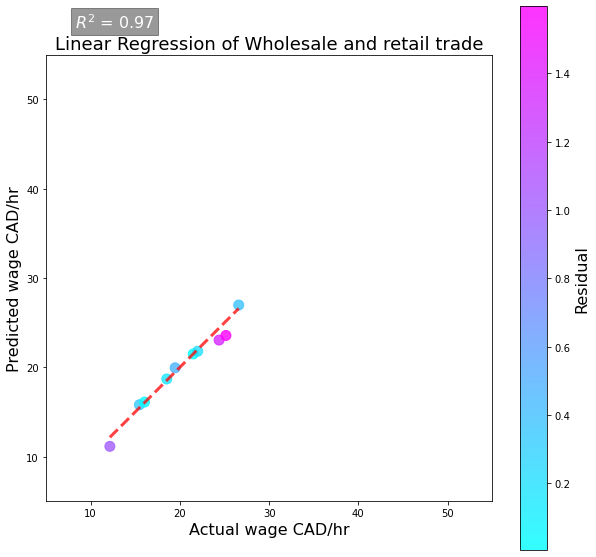

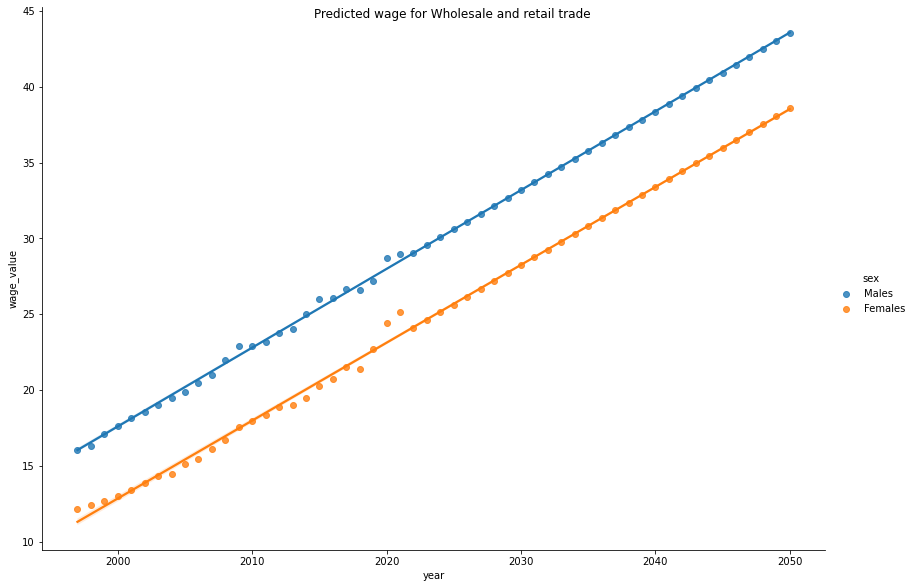

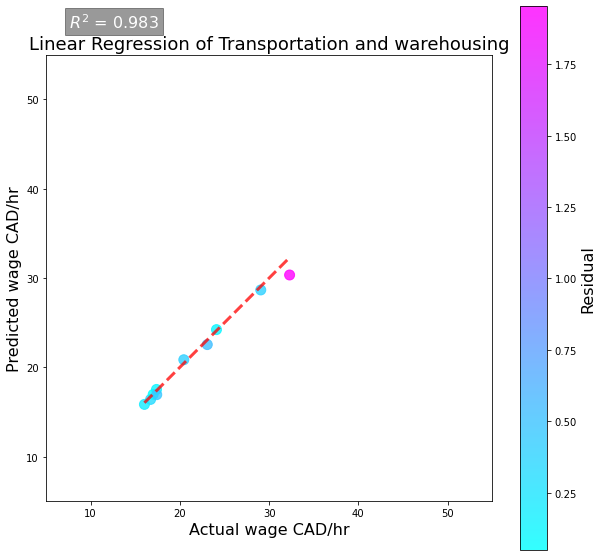

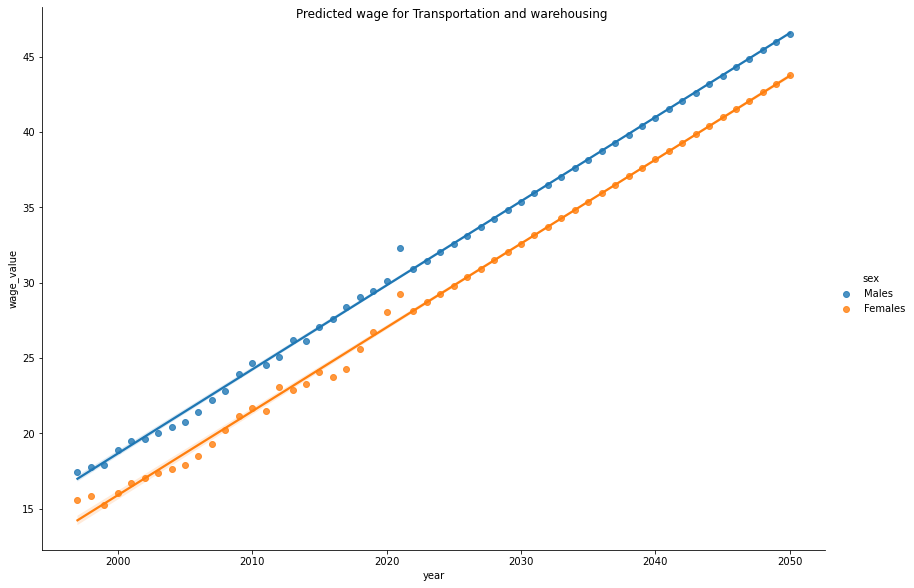

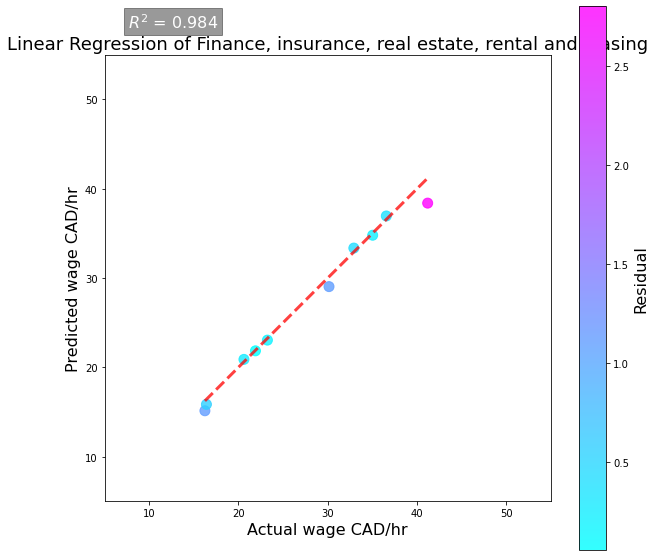

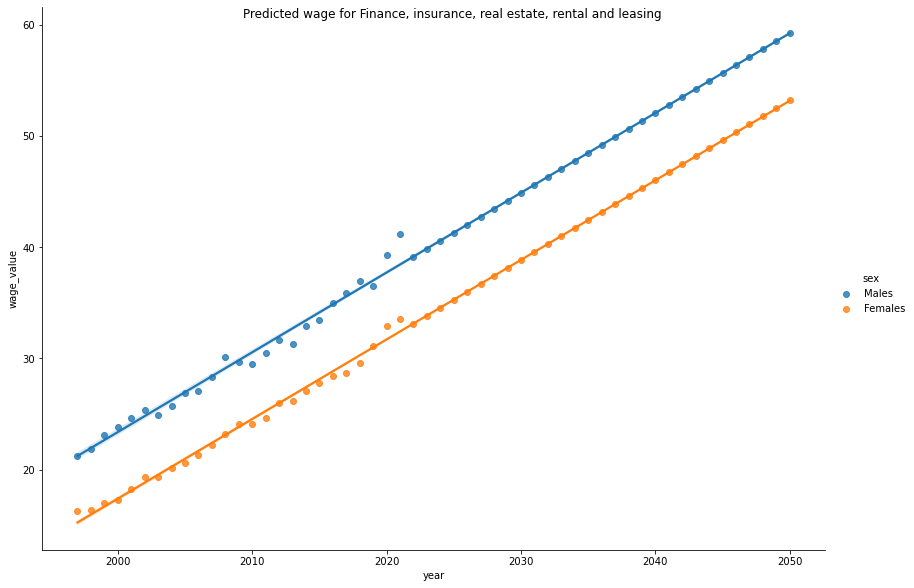

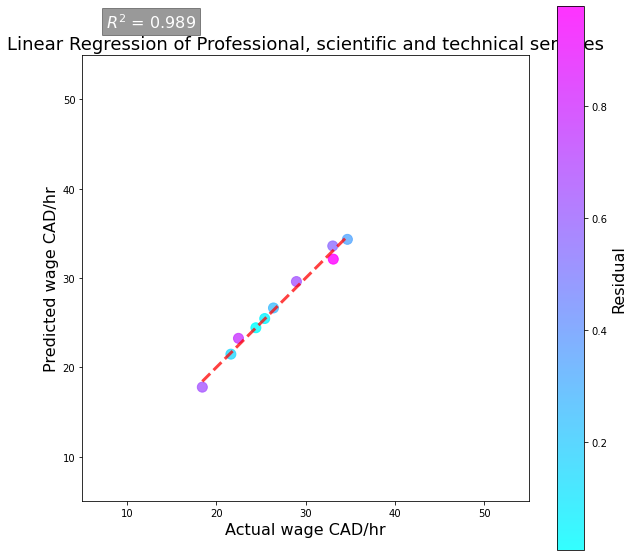

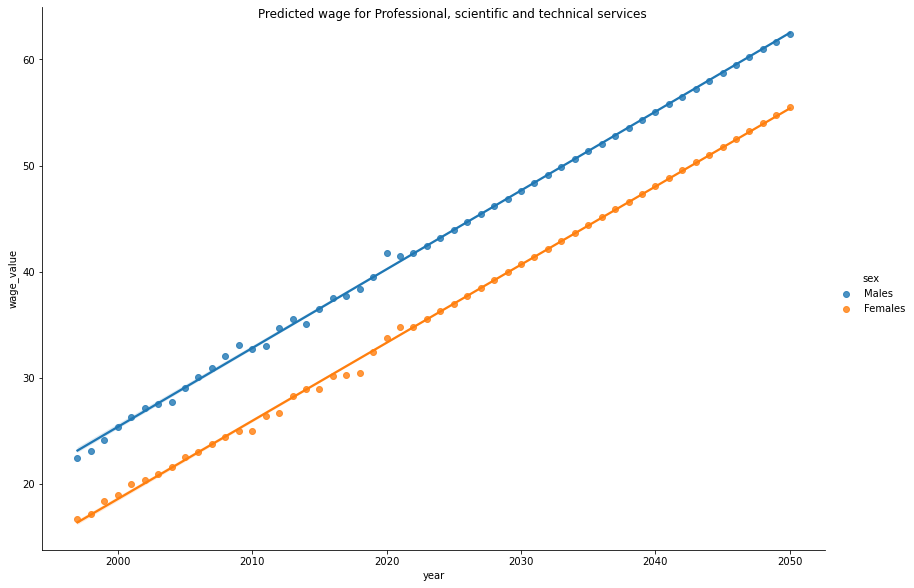

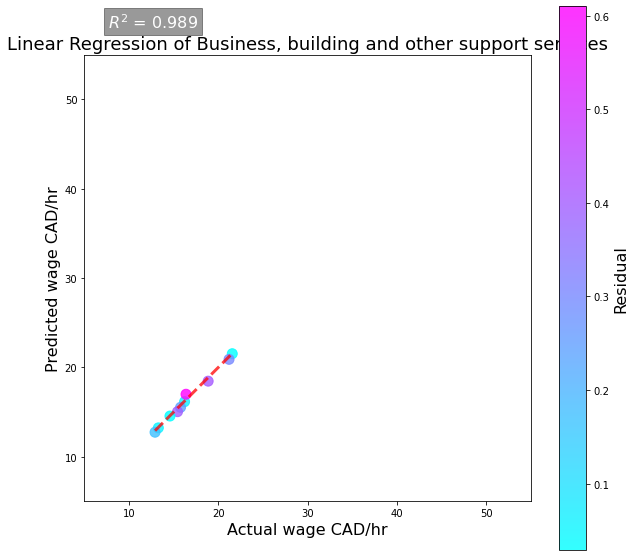

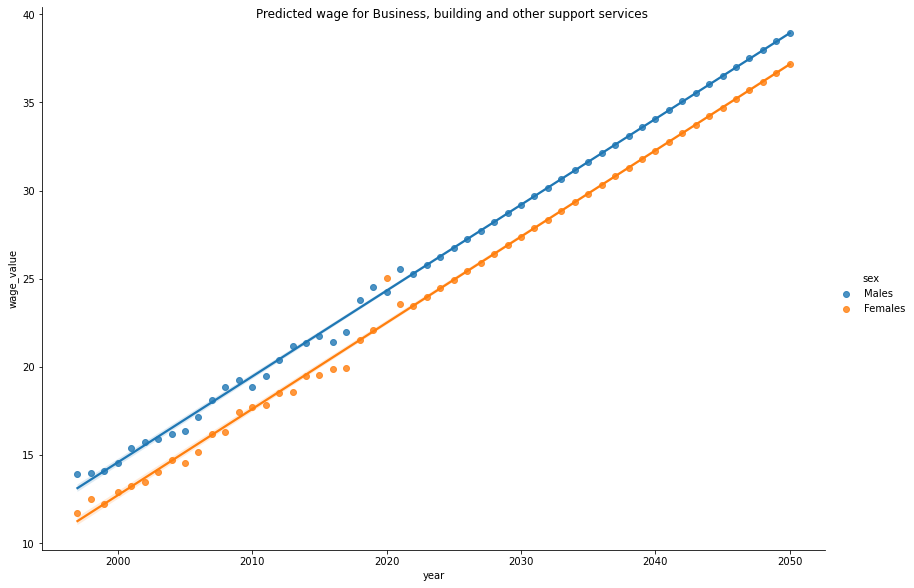

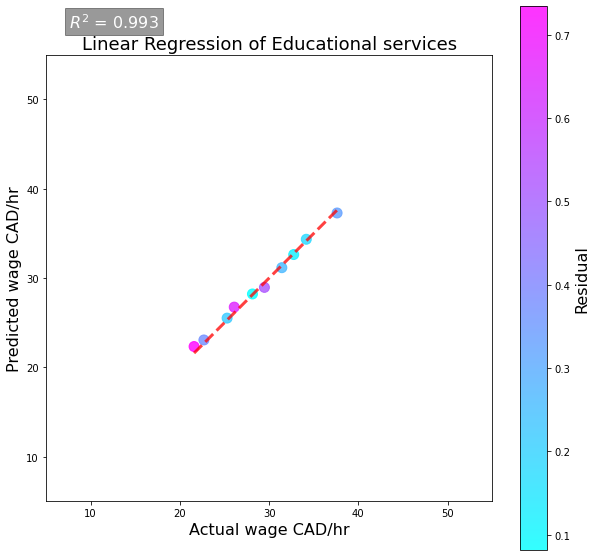

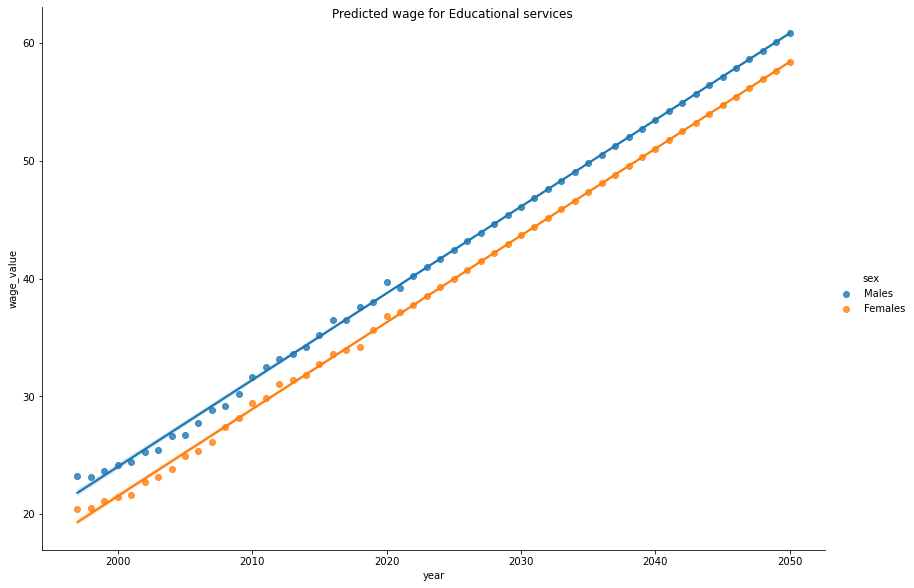

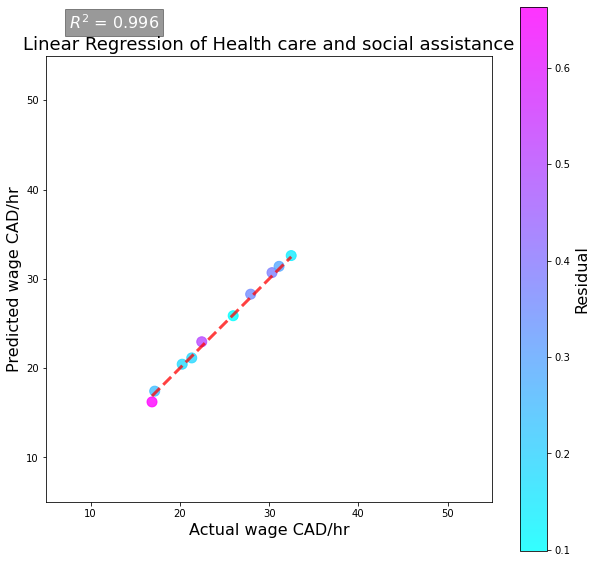

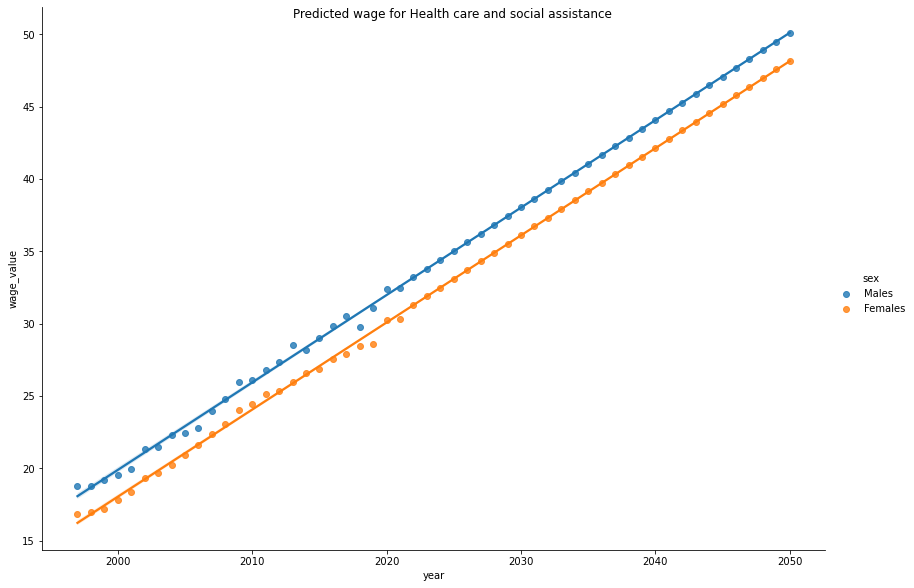

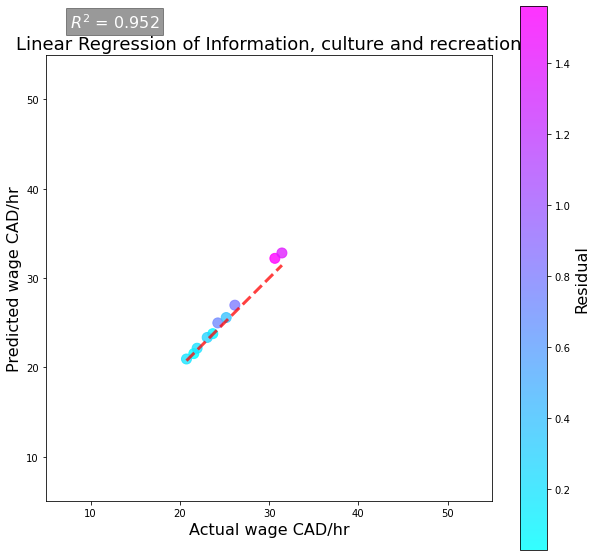

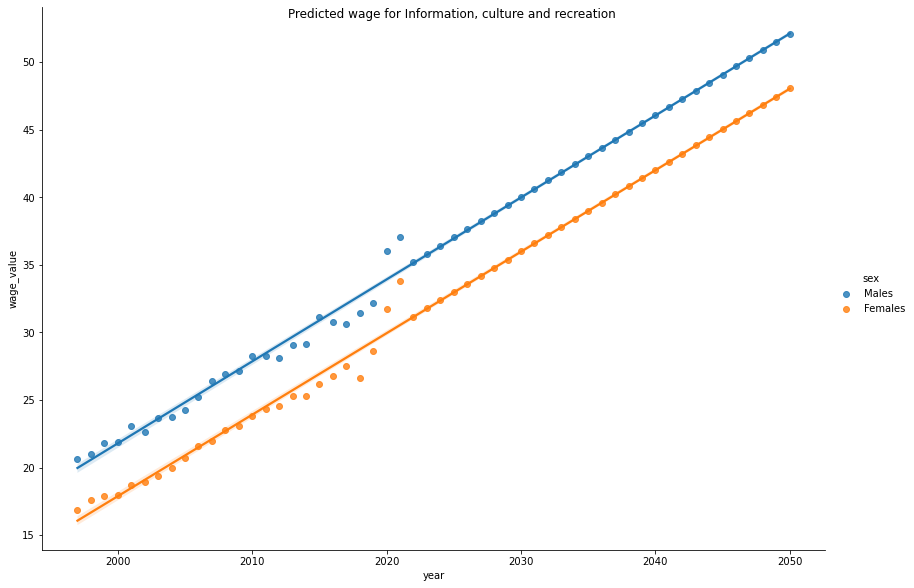

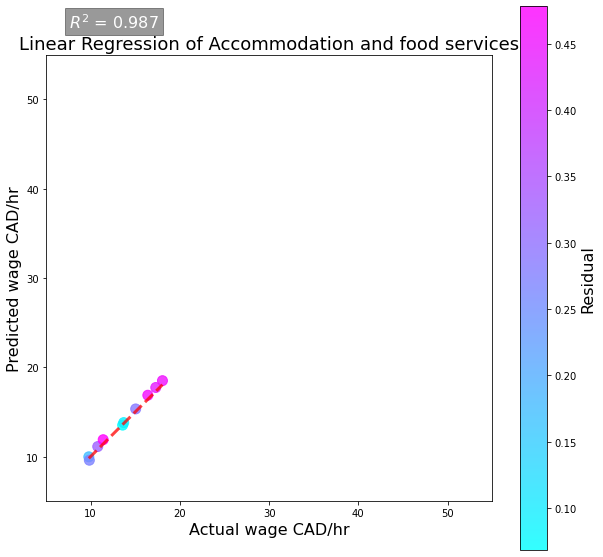

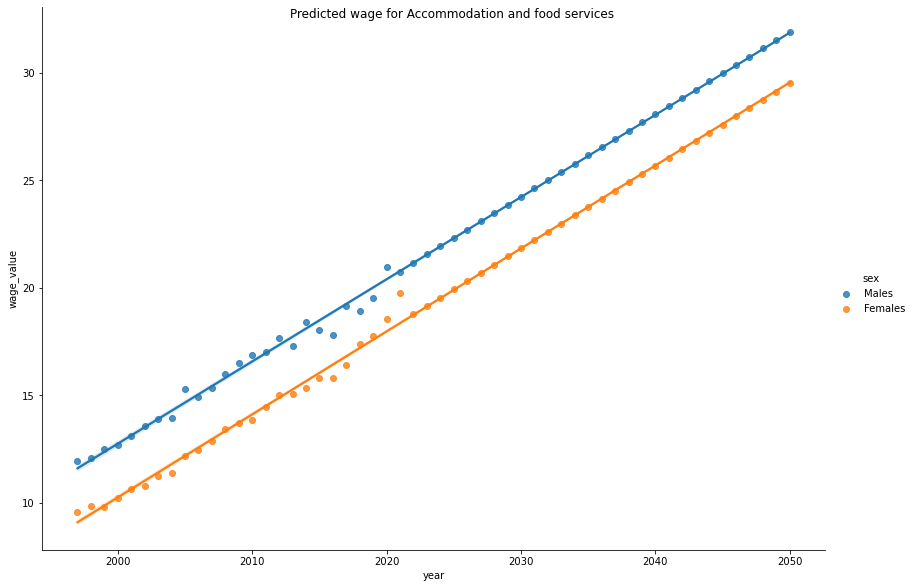

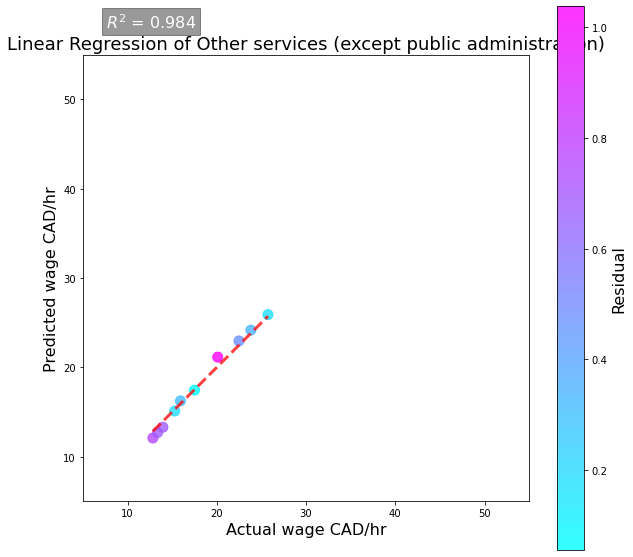

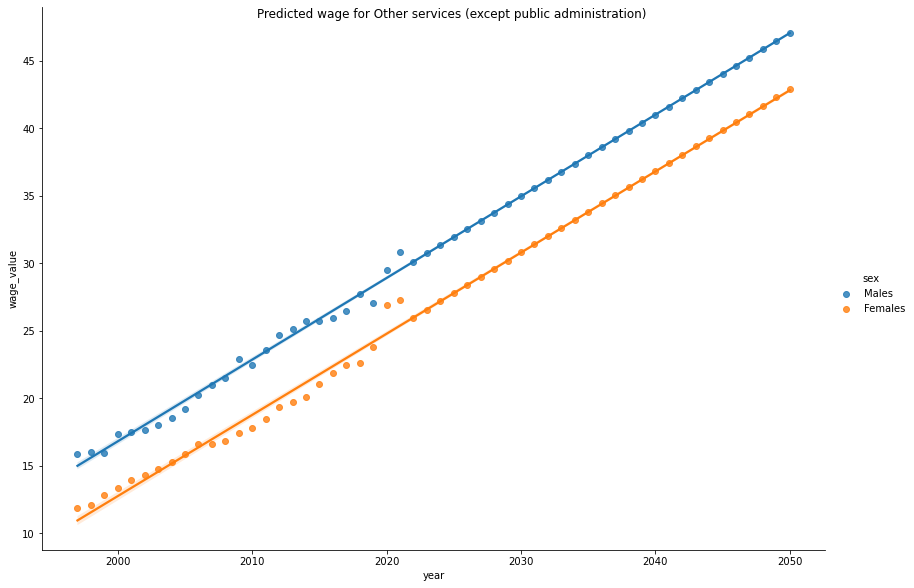

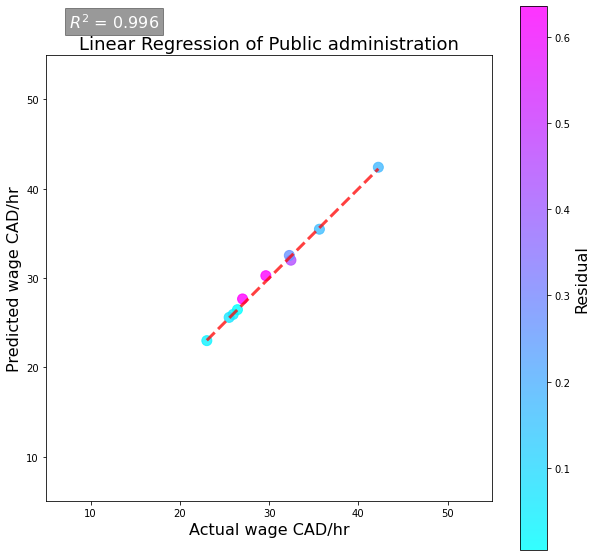

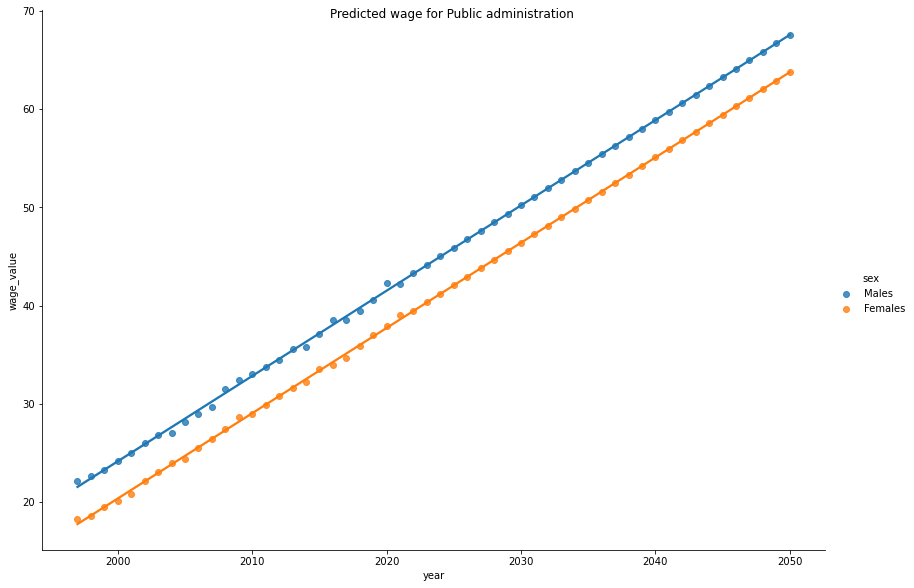

In [13]:
def regression_naics(mfg, industry, pred):
    #mfg as the code was tested on the manufacturing industry, just adjust to make it it's ow
    mfg['sex_c'] = mfg['sex'].map({
        'Males' : 1,
        'Females' : 2})
    X = mfg[['sex_c','year']]
    y = mfg["wage_value"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    scaler = MinMaxScaler() #by default, this will scale each column to between 0 and 1
    scaler = StandardScaler() #by default, this will scale each column to a z-score (how many standard deviations from the mean)
    scaler.fit(X_train) #fit the scaler based on the scale of X_train, and then use the fitted scaler to transform both X_train and X_test (this is the correct way to use the scaler)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    linear_regr = LinearRegression()
    linear_regr.fit(X_train_scaled, y_train)

    y_pred = linear_regr.predict(X_test_scaled) #make predictions for the scaled test set

    #print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("%s R²:"%industry, r2_score(y_test, y_pred))

    # visualizing the predictions
    plot_regression(y_test, y_pred, title="Linear Regression of %s"%industry, axis_label="wage CAD/hr")

    m1, m2 = linear_regr.coef_
    b = linear_regr.intercept_
    
    #prepare a set of data that exceeds to 2050 to run through model
    future_year = np.linspace(2022,2050,num=2050-2022+1)
    future_year = np.append(future_year,np.linspace(2022,2050,num=2050-2022+1))

    future_sex = np.linspace(1,1,29)
    future_sex = np.append(future_sex,np.linspace(2,2,29))

    X_future = pd.DataFrame({'sex_c':future_sex,'year':future_year})

    X_test_scaled = scaler.transform(X_future)

    y_pred = linear_regr.predict(X_test_scaled)

    # visualizing the predictions, clean data frames to accurately append.

    X_future['wage_value']=y_pred
    
    frames = [mfg,X_future]
    mfg_pred=pd.concat(frames)

    mfg_pred['sex_c'] = mfg_pred['sex_c'].map({
        1.0 :'Males', 
        2.0 : 'Females'})
    mfg_pred['sex']=mfg_pred['sex_c']
    mfg_pred['naics']=industry
    mfg_pred = mfg_pred.drop(columns = ['sex_c'])
    
    
    sns.lmplot(x="year", y="wage_value",hue="sex", data=mfg_pred, height=8.27, aspect=11.7/8.27).fig.suptitle("Predicted wage for %s"%industry)

    return mfg_pred 

#can change this interests to whatever you want (i.e., an array of naics strings your interested in)
interests = ft['naics'].unique()

pred = ft
pred.info()

for i in interests:
    temp = regression_naics(ft[ft['naics'] == i],i,pred)
    pred=pred.append(temp)
pred.info()


    


# Predicted for all industries

Text(0.5, 0.98, 'Predicted wages')

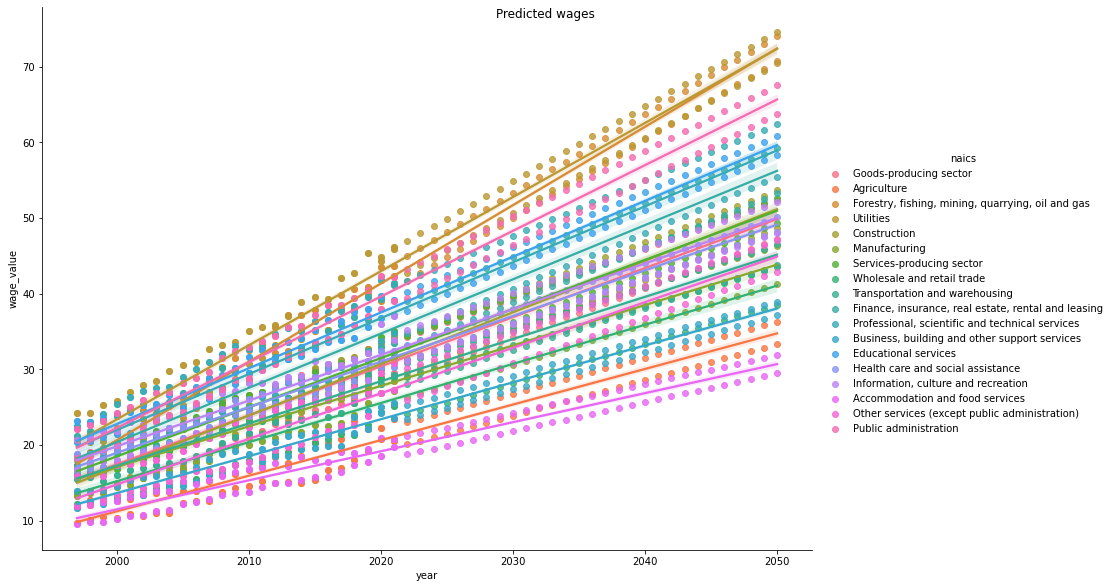

In [14]:
sns.lmplot(x='year',
                 y='wage_value',
                 hue='naics',
                 data=pred,height=8.27, aspect=11.7/8.27).fig.suptitle("Predicted wages")


# Bars comparing industries (simplified)

Snapshot at 2021

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Goods-producing sector'),
  Text(1, 0, 'Agriculture'),
  Text(2, 0, 'Forestry, fishing, mining, quarrying, oil and gas'),
  Text(3, 0, 'Utilities'),
  Text(4, 0, 'Construction'),
  Text(5, 0, 'Manufacturing'),
  Text(6, 0, 'Services-producing sector'),
  Text(7, 0, 'Wholesale and retail trade'),
  Text(8, 0, 'Transportation and warehousing'),
  Text(9, 0, 'Finance, insurance, real estate, rental and leasing'),
  Text(10, 0, 'Professional, scientific and technical services'),
  Text(11, 0, 'Business, building and other support services'),
  Text(12, 0, 'Educational services'),
  Text(13, 0, 'Health care and social assistance'),
  Text(14, 0, 'Information, culture and recreation'),
  Text(15, 0, 'Accommodation and food services'),
  Text(16, 0, 'Other services (except public administration)'),
  Text(17, 0, 'Public administration')])

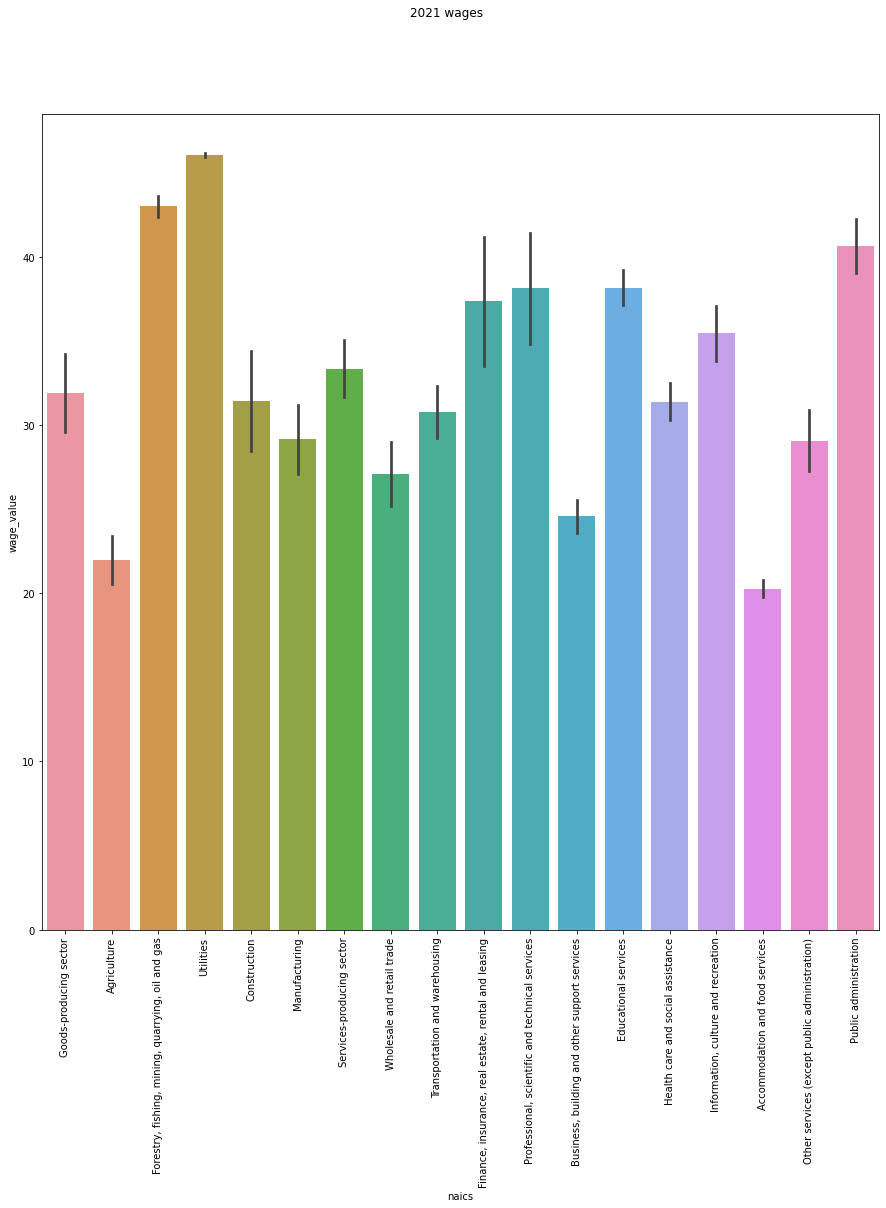

In [38]:
plt.figure(figsize=(15, 15))
sns.barplot(x='naics', y='wage_value',data=ft[ft['year']==2021]).figure.suptitle("2021 wages")
plt.xticks(rotation=90)

Snapshots at 1997, 2021, 2050

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Goods-producing sector'),
  Text(1, 0, 'Agriculture'),
  Text(2, 0, 'Forestry, fishing, mining, quarrying, oil and gas'),
  Text(3, 0, 'Utilities'),
  Text(4, 0, 'Construction'),
  Text(5, 0, 'Manufacturing'),
  Text(6, 0, 'Services-producing sector'),
  Text(7, 0, 'Wholesale and retail trade'),
  Text(8, 0, 'Transportation and warehousing'),
  Text(9, 0, 'Finance, insurance, real estate, rental and leasing'),
  Text(10, 0, 'Professional, scientific and technical services'),
  Text(11, 0, 'Business, building and other support services'),
  Text(12, 0, 'Educational services'),
  Text(13, 0, 'Health care and social assistance'),
  Text(14, 0, 'Information, culture and recreation'),
  Text(15, 0, 'Accommodation and food services'),
  Text(16, 0, 'Other services (except public administration)'),
  Text(17, 0, 'Public administration')])

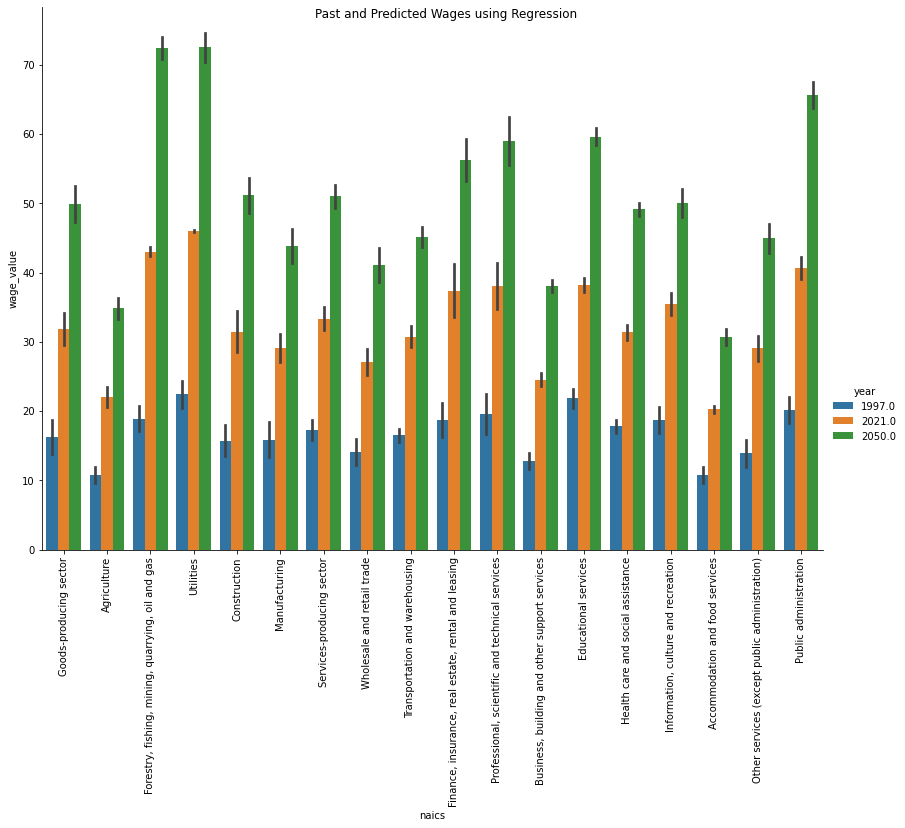

In [22]:
study_years = [1997,2021,2050]
growth = pred.loc[pred['year'].isin(study_years)]

sns.catplot(x='naics', 
            y='wage_value', 
            hue='year', 
            kind='bar', 
            data=growth,
            height=8.27, aspect=11.7/8.27,
            ).fig.suptitle("Past and Predicted Wages using Regression")
plt.xticks(rotation=90)

In [1]:
git remote add origin https://github.com/jamal-shawn/wage_industry_study.git
git branch -M main
git push -u origin main

SyntaxError: invalid syntax (Temp/ipykernel_340704/387921538.py, line 1)